In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn.isotonic as sk_i
import seaborn as sns

# Loading Data

In [9]:
PROJECT_ROOT = Path.cwd().resolve().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

In [10]:
df = pd.read_pickle(PROCESSED_DIR / 'football_model_processed.pickle')
df

,under_pressure,shot_open_goal,shot_first_time,shot_one_on_one,shot_outcome_encoded,player_x,player_y,distance_from_goal_center,distance_from_goal_left_post,distance_from_goal_right_post,...,play_pattern_regular_play,shot_type_free_kick,shot_type_open_play,goalkeeper_x,goalkeeper_y,gk_distance_from_goal_center,gk_distance_from_goal_left_post,gk_distance_from_goal_right_post,shot_angle,distance_player_gk
0,0,0,1,0,0,108.1,31.2,14.800338,12.831602,17.477128,...,1,0,1,119.0,38.7,1.640122,2.879236,5.393515,0.438419,13.231024
1,0,0,1,0,1,110.9,42.6,9.464143,11.241441,9.207063,...,0,0,1,116.0,42.0,4.472136,7.211103,4.472136,0.780138,5.135173
2,1,0,1,0,0,117.9,29.1,11.100450,7.212489,15.047259,...,0,0,1,118.6,39.2,1.612452,3.492850,5.000000,0.155423,10.124228
3,0,0,0,0,1,101.8,27.6,22.022716,20.044949,24.498980,...,0,0,1,97.0,26.8,26.518673,24.771758,28.720028,0.301014,4.866210
4,0,0,0,0,0,109.3,26.5,17.226143,14.308739,20.511948,...,1,0,1,118.3,36.5,3.891015,1.772005,7.690254,0.295954,13.453624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,1,0,0,0,0,98.6,40.4,21.403738,21.847654,21.700691,...,1,0,1,117.4,39.9,2.601922,4.687217,4.854894,0.369445,18.806648
45715,0,0,1,0,0,103.0,51.3,20.412986,22.871161,18.501081,...,0,0,1,115.9,42.2,4.652956,7.433034,4.477723,0.327214,15.786703
45716,0,0,1,0,0,103.8,51.4,19.809089,22.351734,17.810109,...,0,0,1,116.3,42.0,4.205948,7.049113,4.205948,0.331601,15.640013
45717,0,0,0,0,0,110.0,39.4,10.017984,10.562197,11.007270,...,0,0,1,117.5,41.0,2.692582,5.590170,3.905125,0.758877,7.668768


# Preparring the data

In [11]:
# ==============================  
# Train and test split
# ==============================
X = df.drop(columns = {'shot_outcome_encoded'})
y = df['shot_outcome_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=123,
    stratify=y
)
X_train.shape, X_test.shape

((33888, 37), (11297, 37))

In [12]:
cont_cols = [
    col for col in X_train.columns
    if pd.api.types.is_numeric_dtype(X_train[col])       # numeric
    and X_train[col].nunique() > 2              # not binary
]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cont_cols] = scaler.fit_transform(X_train[cont_cols])

X_test_scaled = X_test.copy()
X_test_scaled[cont_cols] = scaler.transform(X_test[cont_cols])

# Training the model

In [13]:
param_grid_ada = {
    'n_estimators': [100, 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],

    # tree depth controls complexity
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5, 10]
}

# -----------------------------
# 2) Create AdaBoost with a default base estimator
# -----------------------------
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=123),
    random_state=123
)

# -----------------------------
# 3) GridSearchCV
# -----------------------------
grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [ ]:
print("Starting GridSearchCV training (AdaBoost)...")
grid_search_ada.fit(X_train_scaled, y_train)
print("GridSearchCV training completed.")

print("Best parameters: ", grid_search_ada.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search_ada.best_score_)

In [ ]:
best_model = grid_search_ada.best_estimator_

In [17]:
best_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, 
                                     min_samples_split=2, 
                                     random_state=123),
                                     learning_rate=0.1,
                                     n_estimators=600,
                                     random_state=123
                                    )

best_model = best_model.fit(X_train_scaled, y_train)

# Evaluating the model


Test Set Performance (AdaBoost):

Test AUC: 0.7984

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10216
           1       0.71      0.10      0.18      1081

    accuracy                           0.91     11297
   macro avg       0.81      0.55      0.56     11297
weighted avg       0.89      0.91      0.88     11297


Confusion Matrix:
[[10172    44]
 [  973   108]]


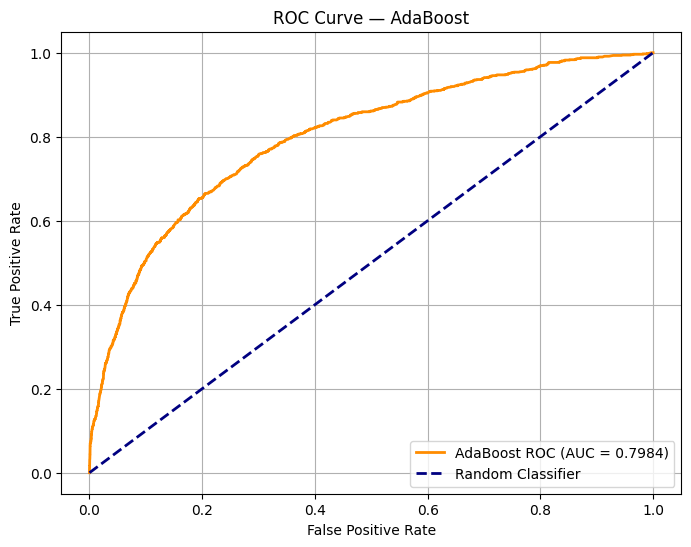

In [23]:
print("\n" + "="*50)
print("Test Set Performance (AdaBoost):")
print("="*50)

y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = best_model.predict(X_test_scaled)

test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest AUC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AdaBoost ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — AdaBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Calibration Curve

In [20]:
import numpy as np
evaluation = pd.DataFrame(y_test_pred_proba, y_test).reset_index()
evaluation.columns = ["outcome", "pred_prob"]

model_probs = np.linspace(0.025, 0.975, num = 20)
true_probs = []

for prob in model_probs:
    true_probs.append(evaluation[(evaluation["pred_prob"] >= prob -0.025) & (evaluation["pred_prob"] <= prob + 0.025)]["outcome"].mean())

In [ ]:
from sklearn.metrics import brier_score_loss

# Compute Brier score for the test set predictions
brier_score = brier_score_loss(y_test, y_test_pred_proba)
print(f"Brier Score: {brier_score:.4f}")

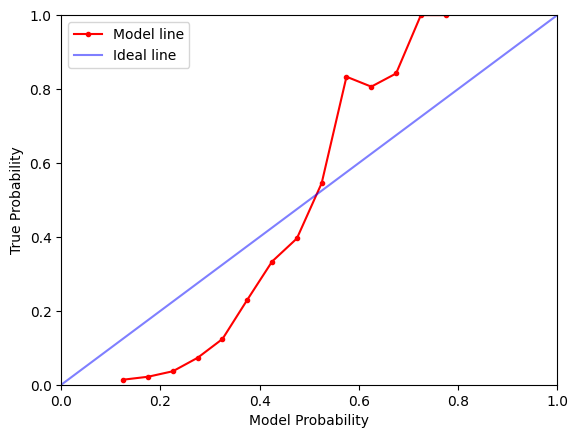

In [21]:
plot_probs = np.linspace(0,1.01, num = 10)

plt.plot(model_probs, true_probs, color = "red", marker='.', label = "Model line")
plt.plot(plot_probs, plot_probs, alpha = 0.5, color = "blue", label = "Ideal line")
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axvspan(0.9, 1, alpha=0.1, label = "No shots with prob > 0.9", color = "red")
plt.legend()
plt.xlabel("Model Probability")
plt.ylabel("True Probability")
plt.show()

## Isotonic Regression

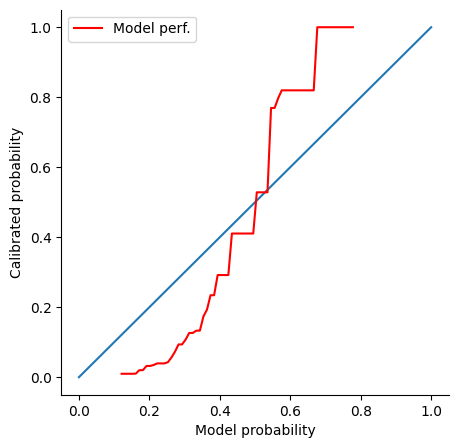

In [22]:
import sklearn.isotonic as sk_i
import seaborn as sns
i_r = sk_i.IsotonicRegression().fit(evaluation["pred_prob"], evaluation["outcome"])

model_probs = np.linspace(0, 1, num=100)

calibrated_probs = i_r.predict(model_probs)

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1])

plt.plot(model_probs, calibrated_probs, color='red', label = "Model perf.")

plt.legend()

plt.xlabel('Model probability')
plt.ylabel('Calibrated probability')

sns.despine()